<a href="https://colab.research.google.com/github/fabiobasson/Bi-Master/blob/main/geological_comparative_InceptionV320102021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project:** Posgraduate Business Intelligence Master PUC-RJ 2021

# **Classification and Prediction of rocks images in drilled wells via Learning Methods Supervised by deep learning and pre trained models**

**geological_similarity/: stores the images of the 6 types of rocks: **   

* andesite/:rock images directory andesite;
*   gneiss/:rock images directory gneiss;
*   marble:rock images directory marble;
*   quartzite:rock images directory quartzite;
*   rhyolite:rock images directory rhyolite
*   schist:drock images directory schist;
    
This work will focus on the analysis of the application of supervised learning methods to the prediction of rock images in drilling wells and represents a new study to be developed by the technical team.

The use of deep learning for the budgeting process has a number of advantages, including the reduction of HH involved, improvement in the degree of assertiveness, speed of response and the possibility of testing different project scenarios in less time.

This work proposes to classify the rocks through their images acquired during geological activities (drilling), using a Deep Learning technique and pre-trained models. 

In [2]:
# Import from libraries

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import os
from os import getcwd

import tensorflow as tf
import zipfile
import sys
import shutil
import numpy as np
import glob
import random
import pandas as pd
import seaborn as sns
import json
import matplotlib.pyplot as plt
from keras.utils import np_utils
from PIL import Image
import plotly.express as px
import cv2 as cv
from imutils import paths
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import classification_report
from sklearn.metrics import hamming_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

from sklearn.model_selection import train_test_split

In [ ]:
# If necessary, remove the directories

#!rm -rf geological_similarity andesite gneiss/ marble/ quartzite/ rhyolite/ schist/
#!rm -rf geological_similarity


# **2. Extraction, Transformation and Loading of the Data**

## **2.1. Kaglle Data Collection**

In [3]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.

#!kaggle datasets download fabiobasson/geologicalsimilarity
#! unzip -qq  geologicalsimilarity
!kaggle datasets download tanyadayanand/geological-image-similarity
! unzip -qq geological-image-similarity   

Saving kaggle.json to kaggle.json
chmod: cannot access '/root/.kaggle/kaggle.': No such file or directory
 77% 26.0M/33.6M [00:00<00:00, 78.2MB/s]
100% 33.6M/33.6M [00:00<00:00, 130MB/s] 


# **Creating the directory structure**

In [4]:
andesite_dir = glob.glob('geological_similarity/andesite/*.jpg');gneiss_dir = glob.glob('geological_similarity/gneiss/*.jpg')
marble_dir= glob.glob('geological_similarity/marble/*.jpg');quartzite_dir = glob.glob('geological_similarity/quartzite/*.jpg')
rhyolite_dir = glob.glob('geological_similarity/rhyolite/*.jpg');
schist_dir = glob.glob('geological_similarity/schist/*.jpg')
print(len(andesite_dir));print(len(gneiss_dir)); print(len(marble_dir)); print(len(quartzite_dir));  print(len(quartzite_dir)); print(len(schist_dir))

andesite_df=[];gneiss_df=[];marble_df=[];quartzite_df=[];rhyolite_df=[];schist_df=[]

label1=['andesite','gneiss','marble','quartzite','rhyolite','schist']

for i in andesite_dir:
    andesite_df.append([i,label1[0]])
for j in gneiss_dir:
   gneiss_df.append([j,label1[1]])
for l in marble_dir:
    marble_df.append([l,label1[2]])
for m in quartzite_dir:
    quartzite_df.append([m,label1[3]])
for n in rhyolite_dir:
    rhyolite_df.append([n,label1[4]])
for o in schist_dir:
    schist_df.append([o,label1[5]])
   
df = andesite_df + gneiss_df + marble_df  + quartzite_df + rhyolite_df + schist_df
random.shuffle(df)
len(df)


5000
5000
4998
5000
5000
5000


29998

# **Creation of Parameters**

In [56]:
INIT_LR = 1e-3
EPOCHS = 200
BS=8

# **Dataframe Creation**

In [6]:
# Criação do Dataframe
data_df = pd.DataFrame(df,columns=['path','label'])
data_df

path      label
0         geological_similarity/marble/LCQAG.jpg     marble
1         geological_similarity/schist/PQEOD.jpg     schist
2         geological_similarity/gneiss/I716Z.jpg     gneiss
3         geological_similarity/schist/WMGV0.jpg     schist
4         geological_similarity/gneiss/W31P6.jpg     gneiss
...                                          ...        ...
29993  geological_similarity/quartzite/XHBQV.jpg  quartzite
29994   geological_similarity/andesite/Y2LXU.jpg   andesite
29995     geological_similarity/schist/SXXYX.jpg     schist
29996     geological_similarity/schist/NCRYP.jpg     schist
29997     geological_similarity/gneiss/59MBT.jpg     gneiss

[29998 rows x 2 columns]

# **Convert the images to 75 by 75**

In [7]:
dados=[]
labels=[]

for imagePath in data_df['path']:

      label = imagePath.split(os.path.sep)[-2]

      image = cv.imread(imagePath)
      image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
      image = cv.resize(image, (75, 75))
      
      dados.append(image)
      labels.append(label)
      
print("labels: ", np.unique(labels))

# Convert data and labels to NumPy arrays while scaling the pixel
dados = np.array(dados) 
labels = np.array(labels)
labels

labels:  ['andesite' 'gneiss' 'marble' 'quartzite' 'rhyolite' 'schist']


array(['marble', 'schist', 'gneiss', ..., 'schist', 'schist', 'gneiss'],
      dtype='<U9')

# **Renaming labels from string format to int**

In [8]:
lb={'andesite':[1, 0, 0, 0, 0, 0] ,'gneiss':[0, 1, 0, 0, 0, 0] ,'marble':[0, 0, 1, 0, 0, 0], 'quartzite':[0, 0, 0, 1, 0, 0], 'rhyolite':[0, 0, 0, 0, 1, 0], 'schist':[0, 0, 0, 0, 0, 1]}
len(labels)

labels1 = [lb[label] for label in labels]
labels1 = np.array(labels1)
print(labels1)

[[0 0 1 0 0 0]
 [0 0 0 0 0 1]
 [0 1 0 0 0 0]
 ...
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 1 0 0 0 0]]


# **Creating the Dataframe on Training, Validation and Testing Data**

In [9]:
X_train, X_test, y_train, y_test  = train_test_split(dados, labels1, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train,test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

print(X_test.shape)
print(y_test.shape)

(17998, 75, 75, 3)
(17998, 6)
(6000, 75, 75, 3)
(6000, 6)
(6000, 75, 75, 3)
(6000, 6)


# **Normalization**

In [10]:
X_train = X_train / 255.
X_val = X_val / 255.
X_test = X_test / 255.

# **Exploring the data**


# **Type: Data Augumentation**

## ** This function will plot the images in a 1 to 5 column grid **

In [11]:
IMG_SHAPE = 75

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [12]:
# Creating the Training and Validation data

datagen = ImageDataGenerator(rescale=1./255,
                            #featurewise_center =False ,
                            # samplewise_center =False ,
                            # featurewise_std_normalization =False ,
                            # samplewise_std_normalization =False ,
                            # zca_whitening =False ,
                            # zca_epsilon =1e -6 ,
                            # channel_shift_range =0. ,
                            # fill_mode = ’ nearest ’ ,
                            # cval =0. ,
                            rotation_range = 40,
                            width_shift_range = 0.2,
                            height_shift_range = 0.2,
                            #shear_range = 0.2,
                            #zoom_range = 0.2,
                            horizontal_flip = True,
                            vertical_flip = True,
                            validation_split=0.2)

datagen_val = ImageDataGenerator (rescale=1./255, 
                                 validation_split=0.2)

In [13]:
train_generator = datagen.flow_from_dataframe (data_df,
    batch_size=BS,
    x_col='path',
    y_col= 'label',
    shuffle=True,
    target_size=(IMG_SHAPE,IMG_SHAPE),
    class_mode='categorical',
    subset='training')

validation_generator = datagen_val.flow_from_dataframe (data_df,
    batch_size=BS,
    x_col='path',
    y_col= 'label',
    shuffle=True,
    target_size=(IMG_SHAPE,IMG_SHAPE),
    class_mode='categorical',
    subset='validation')

Found 23999 validated image filenames belonging to 6 classes.
Found 5999 validated image filenames belonging to 6 classes.


In [14]:
# Test Data

datagen_test = ImageDataGenerator (rescale=1./255, 
                                   #validation_split=0.8,
                                  rotation_range = 40)

test_generator = datagen_test.flow_from_dataframe(data_df,
                                                   batch_size=1,
                                                   x_col='path',
                                                   y_col='label',
                                                   shuffle=False,
                                                   target_size=(IMG_SHAPE,IMG_SHAPE),
                                                   class_mode='categorical')
                                                   #subset='validation')

Found 29998 validated image filenames belonging to 6 classes.


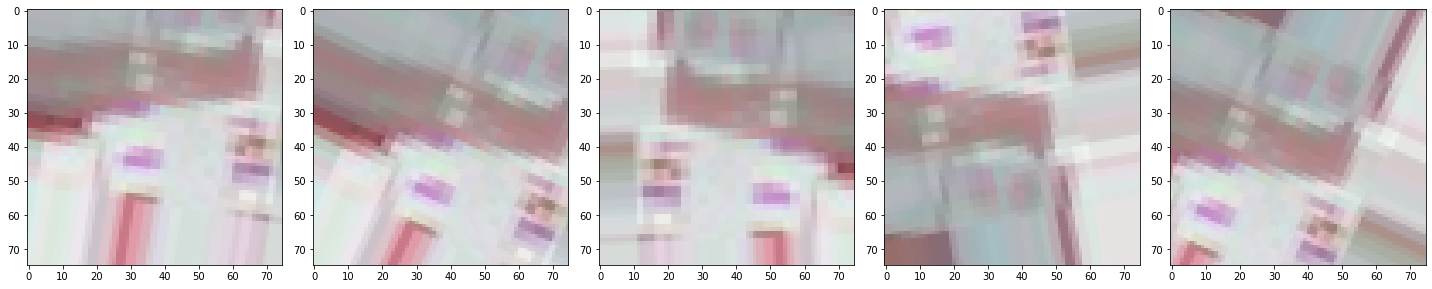

In [15]:
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [16]:
class_dict=test_generator.class_indices
labels= test_generator.labels
file_names= test_generator.filenames 

test_generator.class_indices.keys()

#X_test, y_test = next(test_generator) # não utilizado

dict_keys(['andesite', 'gneiss', 'marble', 'quartzite', 'rhyolite', 'schist'])

# **Perform predictions for classes with the created model**

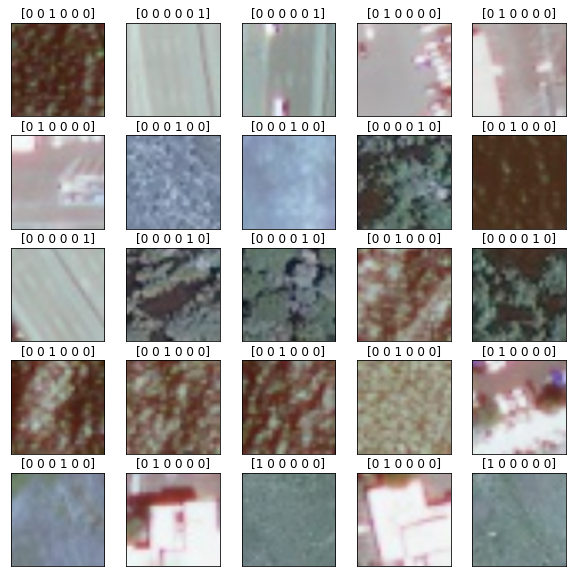

In [17]:
class_names = ['andesite','gneiss','marbler','quartzite','rhyolite','schist']
#class_names = [0,1,2,3,4,5]

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    plt.title(y_train[i])
    #plt.xlabel(y_train[i])
plt.show()
   

# **Listing the networks actually available in your Keras**

In [18]:
import tensorflow.keras.applications as app
print(dir(app))

['DenseNet121', 'DenseNet169', 'DenseNet201', 'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 'EfficientNetB4', 'EfficientNetB5', 'EfficientNetB6', 'EfficientNetB7', 'InceptionResNetV2', 'InceptionV3', 'MobileNet', 'MobileNetV2', 'MobileNetV3Large', 'MobileNetV3Small', 'NASNetLarge', 'NASNetMobile', 'ResNet101', 'ResNet101V2', 'ResNet152', 'ResNet152V2', 'ResNet50', 'ResNet50V2', 'VGG16', 'VGG19', 'Xception', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_sys', 'densenet', 'efficientnet', 'imagenet_utils', 'inception_resnet_v2', 'inception_v3', 'mobilenet', 'mobilenet_v2', 'mobilenet_v3', 'nasnet', 'resnet', 'resnet50', 'resnet_v2', 'vgg16', 'vgg19', 'xception']


## &nbsp;&nbsp;  InceptionNets

Também conhecido como GoogleNet, consiste em um total de 22 camadas e foi o modelo vencedor do desafio de rede de imagens de 2014.

- Módulos de iniciação são o bloco fundamental de InceptionNets. A ideia principal do módulo de iniciação é projetar uma boa topologia de rede local (rede dentro de uma rede)
- Esses módulos ou blocos atuam como o extrator de recursos de vários níveis em que convoluções de tamanhos diferentes são obtidas para criar um mapa de recursos diversificado
- Os módulos de iniciação também consistem em blocos de convolução 1 x 1 cuja função é realizar a redução dimensional.
- Ao realizar a convolução 1x1, o bloco inicial preserva as dimensões espaciais, mas reduz a profundidade. Portanto, as dimensões gerais da rede não aumentam exponencialmente.
- Além da camada de saída regular, esta rede também consiste em duas saídas de classificação auxiliares que são usadas para injetar gradientes nas camadas inferiores.

<br> <br>

O módulo de iniciação é mostrado na figura a seguir:

![](https://hackathonprojects.files.wordpress.com/2016/09/inception_implement.png?w=649&h=337)

A arquitetura completa é mostrada abaixo: 

![](https://cdn-images-1.medium.com/max/2000/1*uXfC5fcbDsL0TJG4T8PsVw.png)
### Pre-Trained Model : InceptionV3

In [57]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-10-20 21:13:47--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.210.128, 173.194.215.128, 173.194.216.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.210.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

inception_v3_weight 100%[===================>]  83.84M   137MB/s    in 0.6s    

2021-10-20 21:13:48 (137 MB/s) - ‘inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



##Pesos da rede 

In [58]:
weights1="/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

##  Transfer Learning

<br>

Vejamos a implementação do aprendizado por transferência usando recursos de modelo pré-treinados. Trunco a rede e paço os dados



In [59]:
pre_trained_model = InceptionV3(input_shape = (75, 75, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(weights1)

for layer in pre_trained_model.layers:
    layer.trainable = False

In [61]:
last_layer = pre_trained_model.get_layer('mixed10')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
#scale_layer = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
#x = scale_layer(last_output)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.

x = tf.keras.layers.GlobalAveragePooling2D()(last_output)

#last_output = last_layer.output
x = layers.Flatten()(x)

x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)                  
x = layers.Dense  (6, activation='softmax')(x)           


modelinceptionv3 = Model( pre_trained_model.input, x) 

modelinceptionv3.summary()

last layer output shape:  (None, 1, 1, 2048)
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 37, 37, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 37, 37, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 37, 37, 32)   0           batch_normalization_188[0][0]    
_______________________________________________

In [89]:
tf.keras.utils.plot_model(modelinceptionv3, show_shapes=True)

In [29]:
from google.colab import drive
drive.mount('/content/drive')

#import os
#workdir_path = '/content/drive/My Drive'  # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)
#os.chdir(workdir_path)

Mounted at /content/drive


In [62]:
modelinceptionv3.compile(optimizer = Adam(learning_rate=0.0001), 
               loss = 'categorical_crossentropy', 
               metrics =['accuracy'])  

callbacksinceptionv3 = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,
                                         patience=4,
                                         verbose=0),
    tf.keras.callbacks.EarlyStopping(
        monitor="accuracy",
        patience=12,
        restore_best_weights=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/My Drive/models/feature_extraction.inceptionv3',
        save_best_only=True,
        monitor="val_accuracy",
        save_weights_only=False,
        mode='max',
        #period=1,
    ),

]

In [63]:
historyinceptionv3 = modelinceptionv3.fit(X_train,y_train,
                    batch_size=BS,
                    epochs=EPOCHS,
                    verbose=1,
                    steps_per_epoch = len(X_train)//BS,
                    callbacks=callbacksinceptionv3,
                    validation_data=(X_val,y_val),
                    validation_steps = len(X_val) //BS)

Epoch 1/200
2249/2249 [==============================] - 258s 112ms/step - loss: 0.8401 - accuracy: 0.6927 - val_loss: 0.4627 - val_accuracy: 0.8302
INFO:tensorflow:Assets written to: /content/drive/My Drive/models/feature_extraction.inceptionv3/assets
Epoch 2/200
2249/2249 [==============================] - 247s 110ms/step - loss: 0.4903 - accuracy: 0.8178 - val_loss: 0.3853 - val_accuracy: 0.8538
INFO:tensorflow:Assets written to: /content/drive/My Drive/models/feature_extraction.inceptionv3/assets
Epoch 3/200
2249/2249 [==============================] - 247s 110ms/step - loss: 0.4213 - accuracy: 0.8427 - val_loss: 0.3542 - val_accuracy: 0.8678
INFO:tensorflow:Assets written to: /content/drive/My Drive/models/feature_extraction.inceptionv3/assets
Epoch 4/200
2249/2249 [==============================] - 249s 111ms/step - loss: 0.3752 - accuracy: 0.8606 - val_loss: 0.3363 - val_accuracy: 0.8757
INFO:tensorflow:Assets written to: /content/drive/My Drive/models/feature_extraction.incepti

# **Save the model Inception V3**

In [77]:
from keras.models import model_from_json

def save_model(modelinceptionv3):
    # saving model
    json_model = modelinceptionv3.to_json()
    open('/content/drive/My Drive/models/model_inceptionv3.json', 'w').write(json_model)
    # saving weights
    modelinceptionv3.save_weights('/content/drive/My Drive/models/inceptionv3_weights.h5', overwrite=True)

In [65]:
def load_model():
    # loading model
    modelinceptionv3 = model_from_json(open('/content/drive/My Drive/models/model_inceptionv3.json').read())
    modelinceptionv3.load_weights('/content/drive/My Drive/models/inceptionv3_weights.h5')
    modelinceptionv3.compile(optimizer = Adam(learning_rate=0.0001), 
               loss = 'categorical_crossentropy', 
               metrics =['accuracy']) 
    return modelinceptionv3

In [78]:
# save the model Inception V3
save_model(modelinceptionv3)

### **Evaluate Accuracy Model Inception V3 **

In [79]:
# (ref http://stackoverflow.com/q/32239577/395857)

def hamming_score(y_true, y_pred):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [82]:
#modelinceptionv3 = tf.keras.models.load_model("/content/drive/My Drive/models/feature_extraction.inceptionv3")
# load the model
modelinceptionv3 = load_model()

y_pred = modelinceptionv3.predict(X_test,batch_size=BS)

test_loss, test_acc= modelinceptionv3.evaluate(X_test,y_test)
print("validation_accuracy: " + str(test_acc))

print("-------\n")

print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

print("-------\n")

# In such a situation, Hamming loss is a good measure of model performance.
# Decrease Hamming loss, better model performance.
# For the above labels, Hamming loss is 0.XXX as calculated below.

hs = hamming_score(y_test, y_pred)
print(f"Hamming loss: {hs}")
print("-------\n")

188/188 [==============================] - 52s 265ms/step - loss: 0.2991 - accuracy: 0.8933
validation_accuracy: 0.8933333158493042
-------

Test accuracy: 0.8933333158493042
Test loss: 0.2990945279598236
-------

Hamming loss: 0.16666666666666666
-------



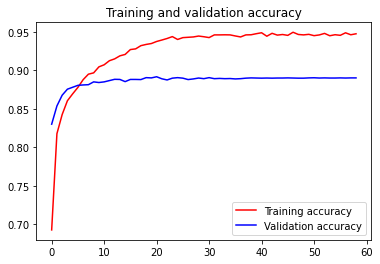

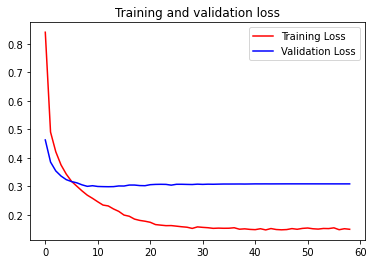

In [83]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = historyinceptionv3.history['accuracy']
val_acc = historyinceptionv3.history['val_accuracy']
loss = historyinceptionv3.history['loss']
val_loss = historyinceptionv3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# **Perform predictions for classes with the created model**

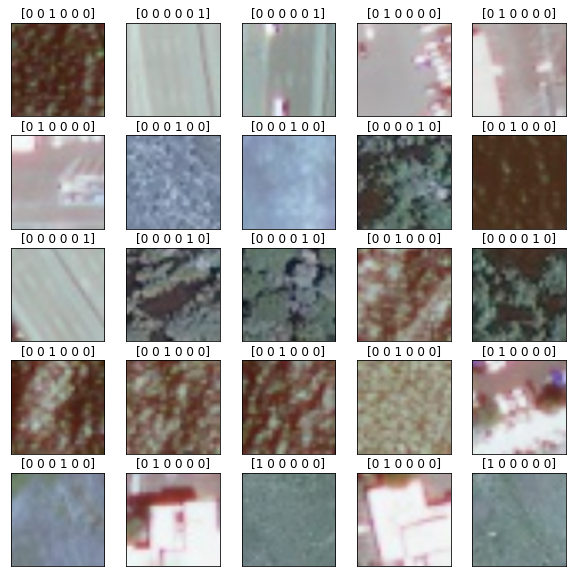

In [84]:
class_names = ['andesite','gneiss','marbler','quartzite','rhyolite','schist']
#class_names = [0,1,2,3,4,5]

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    plt.title(y_train[i])
    #plt.xlabel(y_train[i])
plt.show()
   

# **Classification report**
We can summarize the performance of our classifier as follows:

In [85]:
# Make predictions on the test set
#print("[INFO] evaluating network...")
#y_pred = model.predict(X_test,batch_size=BS)

# For each image in the test set, we need to find the index of the
# label with the corresponding highest predicted probability
y_pred = np.argmax(y_pred, axis=1)

# Shows a well-formatted ranking report
print(classification_report(y_test.argmax(axis=1), y_pred,target_names=lb))

#Get the indices to be plotted
#y_true = 
#correct = np.nonzero(y_pred==y_true)[0]
#incorrect = np.nonzero(y_pred!=y_true)[0]
#from sklearn.metrics import classification_report
#target_names = ["Class {}".format(i) for i in range(num_classes)]
#print(classification_report(y_true, y_pred, target_names=target_names))'''

              precision    recall  f1-score   support

    andesite       0.79      0.79      0.79      1001
      gneiss       0.91      0.90      0.90      1061
      marble       0.99      0.99      0.99       998
   quartzite       0.81      0.81      0.81       968
    rhyolite       0.93      0.94      0.94      1000
      schist       0.92      0.92      0.92       972

    accuracy                           0.89      6000
   macro avg       0.89      0.89      0.89      6000
weighted avg       0.89      0.89      0.89      6000



# **the confusion matrix**

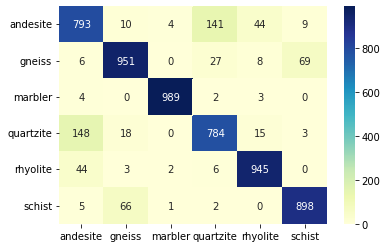

In [86]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test.argmax(axis=1),y_pred)

# show the confusion matrix
#print(cm)

cm_matrix = pd.DataFrame(data=cm, columns=['andesite','gneiss','marbler','quartzite','rhyolite','schist'], 
                                 index=['andesite','gneiss','marbler','quartzite','rhyolite','schist'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [87]:
# Calculate the confusion matrix and use it to derive the
# precision, sensitivity and specificitye

total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# Show accuracy, sensitivity and specificity
print("acc: {:.4f}".format(acc))

acc: 0.2907


# **Confusion matrix with heat map**

In [88]:
true_classes = test_generator.classes
class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

scratch_preds = modelinceptionv3.predict(test_generator)
scratch_pred_classes = np.argmax(scratch_preds, axis=1)

#vgg_preds = model.predict(test_generator)
#vgg_pred_classes = np.argmax(vgg_preds, axis=1)

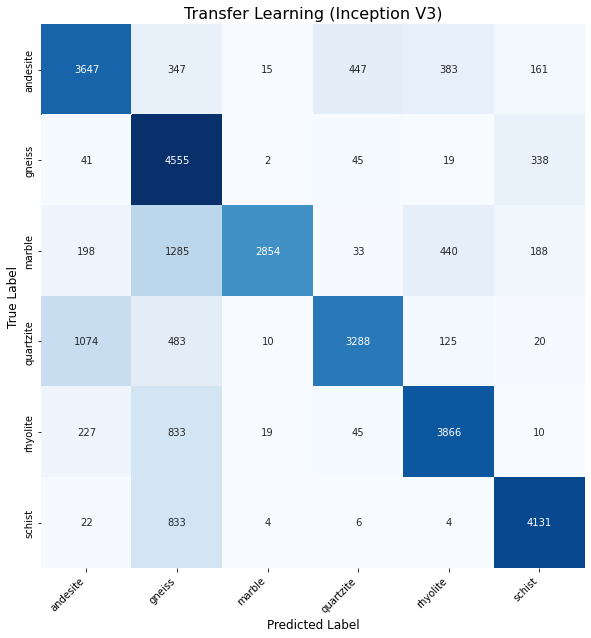

In [90]:
# Get the names of the six classes
class_names1 = test_generator.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names1, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names1, 
        yticklabels=class_names1,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

#fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20, 10))
fig, (ax1) = plt.subplots(1, 1, figsize=(20, 10))

plot_heatmap(true_classes, scratch_pred_classes, class_names1, ax1, title="Transfer Learning (Inception V3)")    
#plot_heatmap(true_classes, vgg_pred_classes, class_names1, ax2, title="Transfer Learning (VGG16)")    
#plot_heatmap(true_classes, vgg_pred_classes_ft, class_names1, ax3, title="Transfer Learning (VGG16) with Fine-Tuning") 